In [ ]:
import talib
# Imports
import yfinance as yf
import pandas as pd
import numpy as np
from pathlib import Path
import hvplot.pandas
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [2]:
# Download historical market data
ticker = "SPY"
stock = yf.Ticker(ticker)

# get historical market data
hist = stock.history(period="3y")

In [3]:
# Download historical data as dataframe
spy_data = yf.download('SPY', start='2020-01-01', end='2023-06-30')

[*********************100%***********************]  1 of 1 completed


In [4]:
spy_data.to_csv('SPY_data.csv')

In [5]:
spy_df =pd.read_csv('SPY_data.csv')
spy_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-02,323.540009,324.890015,322.529999,324.869995,307.375610,59151200
1,2020-01-03,321.160004,323.640015,321.100006,322.410004,305.048187,77709700
2,2020-01-06,320.489990,323.730011,320.359985,323.640015,306.211884,55653900
3,2020-01-07,323.019989,323.540009,322.239990,322.730011,305.350922,40496400
4,2020-01-08,322.940002,325.779999,322.670013,324.450012,306.978302,68296000


In [17]:
spy_df.loc[:, ["""Close"]]

,Close
0,324.869995
1,322.410004
2,323.640015
3,322.730011
4,324.450012
...,...
874,433.209991
875,431.440002
876,436.170013
877,436.390015


In [6]:
# Extract the 'Close' prices
data = spy_df['Close'].values.reshape(-1, 1)

In [7]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [8]:
# Split the data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [9]:
# Create input-output sequences
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

In [10]:
window_size = 30  # Number of previous days' closing prices to consider
X_train, y_train = create_sequences(train_data, window_size)
X_test, y_test = create_sequences(test_data, window_size)

In [11]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(64,input_shape=(window_size, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=16)

# Evaluate the model
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)
print('Train Loss:', train_loss)
print('Test Loss:', test_loss)


Epoch 1/10
43/43 [==============================] - 5s 17ms/step - loss: 0.0555
Epoch 2/10
43/43 [==============================] - 1s 17ms/step - loss: 0.0030
Epoch 3/10
43/43 [==============================] - 1s 18ms/step - loss: 0.0022
Epoch 4/10
43/43 [==============================] - 1s 20ms/step - loss: 0.0018
Epoch 5/10
43/43 [==============================] - 1s 18ms/step - loss: 0.0019
Epoch 6/10
43/43 [==============================] - 1s 18ms/step - loss: 0.0018
Epoch 7/10
43/43 [==============================] - 1s 19ms/step - loss: 0.0018
Epoch 8/10
43/43 [==============================] - 1s 18ms/step - loss: 0.0017
Epoch 9/10
43/43 [==============================] - 1s 17ms/step - loss: 0.0016
Epoch 10/10
43/43 [==============================] - 1s 18ms/step - loss: 0.0015
Train Loss: 0.0014791784342378378
Test Loss: 0.0008084867731668055


In [14]:
# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)


5/5 [==============================] - 0s 8ms/step


In [15]:
# Inverse scale the predictions
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)

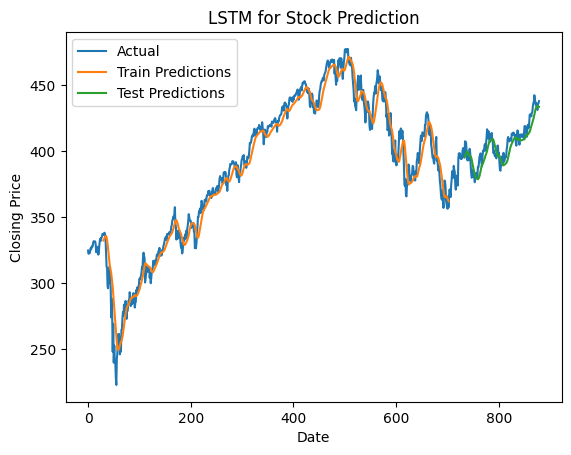

In [18]:
# Plot the predicted and actual closing prices
plt.plot(spy_df['Close'], label='Actual')
plt.plot(range(window_size, train_size), train_predictions, label='Train Predictions')
plt.plot(range(train_size + window_size, len(data)), test_predictions, label='Test Predictions')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('LSTM for Stock Prediction')
plt.legend()
plt.show()